In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from collections import defaultdict
from collections import Counter
from PIL import Image


In [2]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


In [34]:
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset:", path)

Path to dataset: C:\Users\jli20\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [35]:
def convert_all_to_rgb(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(file_path)
            except Exception as e:
                print(f"Failed on {file_path}: {e}")

In [36]:
data_path = os.path.join(path, 'data')
subfolders = os.listdir(data_path)
print("Class folders:", subfolders)
convert_all_to_rgb(data_path)

Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [37]:
img_size = (224, 224)
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)

unbatched_ds = dataset.unbatch()

class_names = dataset.class_names
print("Class names:", class_names)

Found 5631 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [38]:
"""
{
  'cloudy': [(img1, lbl1), (img2, lbl2)]
  'desert': [.......]
  ......
}
"""

class_datasets = defaultdict(list)

for image, label in unbatched_ds:
    class_idx = int(label.numpy())
    class_name = class_names[class_idx]
    class_datasets[class_name].append((image, label))

In [39]:
def make_class_dataset(data_tuples, batch_size):
    imgs, labels = zip(*data_tuples)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
cloudy_ds = make_class_dataset(class_datasets["cloudy"], batch_size)
desert_ds = make_class_dataset(class_datasets["desert"], batch_size)
green_ds  = make_class_dataset(class_datasets["green_area"], batch_size)
water_ds  = make_class_dataset(class_datasets["water"], batch_size)

In [41]:
def count_images(dataset):
    return sum(1 for _ in dataset.unbatch())

In [42]:
print("Cloudy images:", count_images(cloudy_ds))
print("Desert images:", count_images(desert_ds))
print("Green images:", count_images(green_ds))
print("Water images:", count_images(water_ds))

Cloudy images: 1500
Desert images: 1131
Green images: 1500
Water images: 1500


In [43]:
for image, label in cloudy_ds.take(1):
    print("Min:", tf.reduce_min(image).numpy())
    print("Max:", tf.reduce_max(image).numpy())
    print("Mean:", tf.reduce_mean(image).numpy())

Min: 22.285706
Max: 236.0
Mean: 149.27696


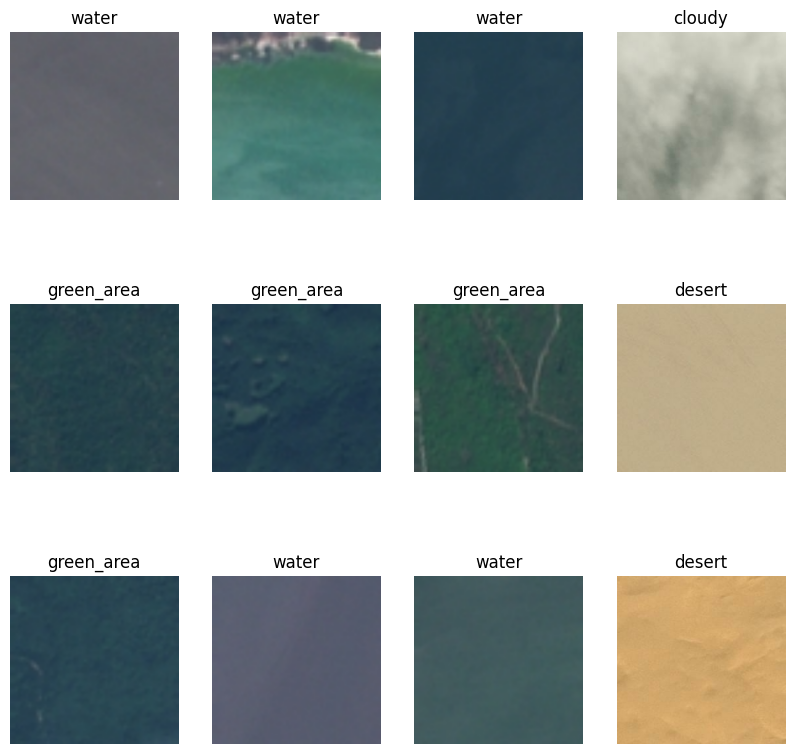

In [44]:
class_names = dataset.class_names

number_of_images = 12

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(number_of_images//4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,      # 20% for validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Train images:", tf.data.experimental.cardinality(train_ds).numpy() * 16)
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Val images:", tf.data.experimental.cardinality(val_ds).numpy() * 16)



Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Train batches: 141
Train images: 2256
Val batches: 36
Val images: 576


In [46]:
def count_class_number(dataset):
    train_counter = Counter()

    for _, label in dataset.unbatch():
        train_counter[int(label.numpy())] += 1

    # Map class indices to names
    class_names = dataset.class_names
    train_distribution = {class_names[i]: count for i, count in train_counter.items()}

    print("Training set class distribution:")
    for k, v in train_distribution.items():
        print(f"{k}: {v}")

In [47]:
shuffled_cloudy = (
    cloudy_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_green = (
    green_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_desert = (
    desert_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_water = (
    water_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [48]:
print(type(water_ds))
print(type(shuffled_water))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


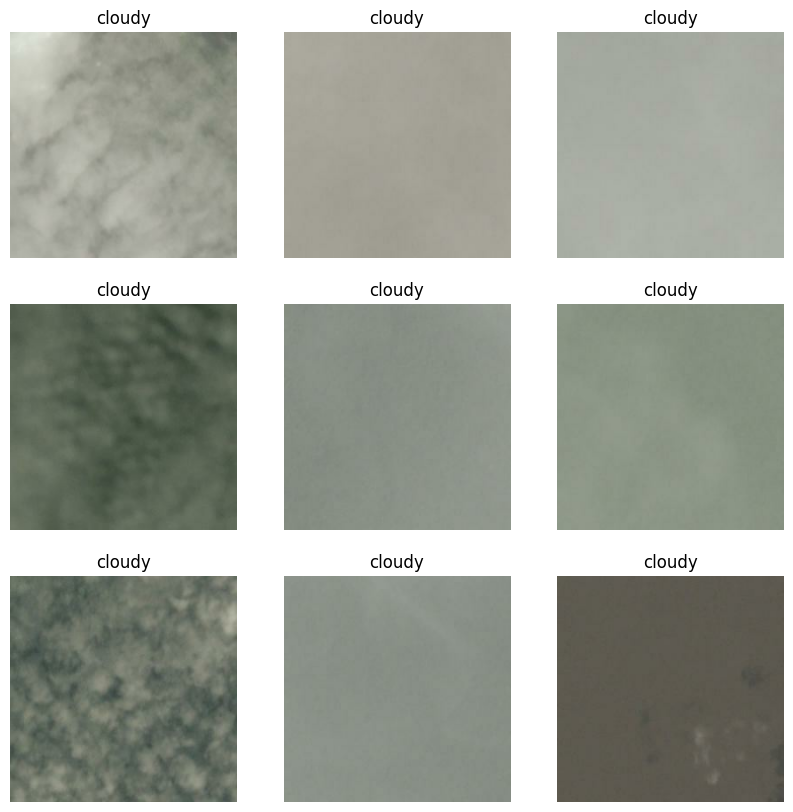

In [49]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_cloudy.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

In [50]:
pre_split_cloudy = list(shuffled_cloudy.unbatch())
pre_split_green = list(shuffled_green.unbatch())
pre_split_water = list(shuffled_water.unbatch())
pre_split_desert = list(shuffled_desert.unbatch())

In [51]:
def relabel(data, new_label):
    return [(img, tf.constant(new_label)) for (img, _) in data]

cloudy = relabel(pre_split_cloudy, 0)
desert = relabel(pre_split_cloudy, 1)
green  = relabel(pre_split_green, 2)
water  = relabel(pre_split_water, 3)

In [52]:
def dataset_split(data, train_ratio):
    i = int(len(data) * train_ratio)
    return data[:i], data[i:]

In [53]:
cloudy_train, cloudy_val = dataset_split(pre_split_cloudy, 0.8)
green_train, green_val = dataset_split(pre_split_green, 0.8)
water_train, water_val = dataset_split(pre_split_water, 0.8)
desert_train, desert_val = dataset_split(pre_split_desert, 0.8)


In [54]:
train_data = cloudy_train + desert_train + green_train + water_train
val_data   = cloudy_val + desert_val + green_val + water_val

In [55]:
def to_tf_dataset(data, batch_size):
    imgs, labels = zip(*data)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [56]:
batch_size = 32
train_ds = to_tf_dataset(train_data, batch_size)
val_ds   = to_tf_dataset(val_data, batch_size)

In [65]:
train_ds = train_ds.shuffle(buffer_size=10000)
val_ds = val_ds.shuffle(buffer_size=5000)

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [73]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
label_counts = Counter()

for _, label in train_ds.unbatch():
    label_counts[int(label.numpy())] += 1

print("Training label distribution:")
for class_index, count in label_counts.items():
    print(f"Class {class_index}: {count} samples")

Training label distribution:
Class 1: 904 samples
Class 2: 1200 samples
Class 0: 1200 samples
Class 3: 1200 samples


In [ ]:
# print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


In [ ]:
# import tensorflow as tf
# print(tf.__file__)

c:\Users\jli20\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\__init__.py


In [74]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30


141/141 ━━━━━━━━━━━━━━━━━━━━ 129s 797ms/step - accuracy: 0.3782 - loss: 1.7333 - val_accuracy: 0.6424 - val_loss: 0.8146
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 124s 783ms/step - accuracy: 0.4438 - loss: 0.8412 - val_accuracy: 0.6371 - val_loss: 0.8541
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 120s 792ms/step - accuracy: 0.4917 - loss: 0.7937 - val_accuracy: 0.7090 - val_loss: 0.6044
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 118s 772ms/step - accuracy: 0.6324 - loss: 0.7042 - val_accuracy: 0.6327 - val_loss: 0.7021
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 115s 767ms/step - accuracy: 0.5227 - loss: 0.7636 - val_accuracy: 0.7054 - val_loss: 0.5769
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 116s 779ms/step - accuracy: 0.6331 - loss: 0.6574 - val_accuracy: 0.7072 - val_loss: 0.5022
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 114s 771ms/step - accuracy: 0.6595 - loss: 0.5822 - val_accuracy: 0.7001 - val_loss: 0.5004
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 114s 774ms/step - accuracy: 0.6870 - loss: 0.57

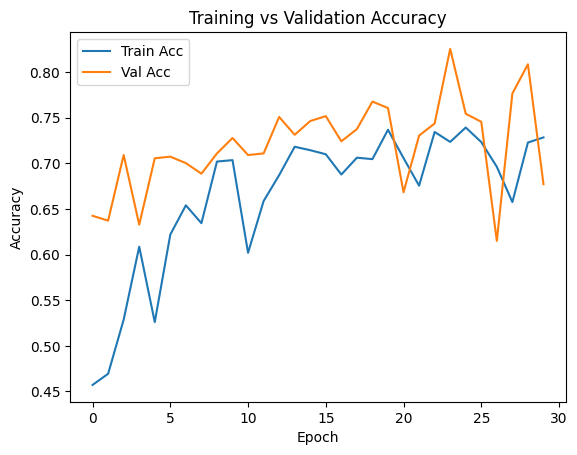

In [75]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

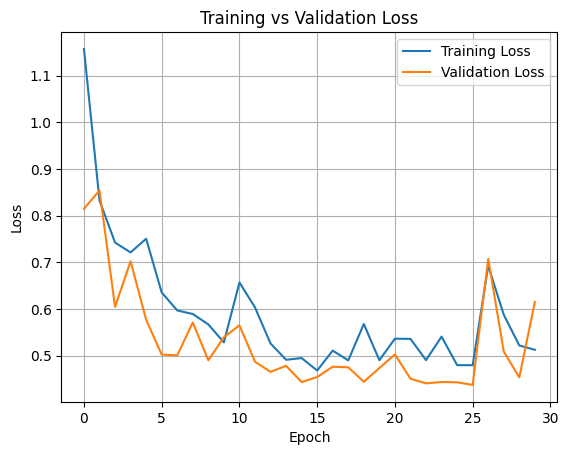

In [76]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
print(tf.__version__)

2.19.0
